In [1]:
dir_data = '../data/skin-cancer'
dir_ckpt = './outputs/ckpt'

seed = 0
method = 'persistence-image'
n_bins = 28

n_classes = 7
input_shape = {'img': (28, 28, 1), 'tda': (n_bins, n_bins, 2)}

In [2]:
import sys
sys.path.append('../')

from cnntdanet.utils import seed_all
from cnntdanet.tda import get_tda_pipeline
from cnntdanet.models import get_cnn_net, get_wide_cnn_net, get_cnn_tda_net
from cnntdanet.utils.plotting import plot_learning_curve
from cnntdanet.gradcam import GradCAMOnCNN, GradCAMOnCNNTDANet

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [3]:
seed_all(seed)

In [4]:
# Preparing dataset
df = pd.read_csv(os.path.join(dir_data, 'hmnist_28_28_L.csv'))

X = df.drop('label', axis=1).values.reshape((-1, *input_shape['img']))
X = X.astype(np.float32)
X /= 255.0

y = df['label'].values
y = y.astype(np.int64)

## TDA features
pipeline = get_tda_pipeline(method=method, n_bins=n_bins)

X_tda = pipeline.fit_transform(X)
X_tda = X_tda.astype(np.float32)

In [5]:
# Splitting data
y_ = y.copy()  # For stratification

train_indices, valid_indices = train_test_split(np.arange(len(X)), stratify=y_, test_size=0.2, random_state=seed)

## One-hot encoding
y = tf.keras.utils.to_categorical(y_, n_classes) 

X_img_train, X_tda_train, y_train = X[train_indices], X_tda[train_indices], y[train_indices]
X_img_valid, X_tda_valid, y_valid = X[valid_indices], X_tda[valid_indices], y[valid_indices]

In [6]:
# Build a single 2D-CNN network
cnn = get_cnn_net(input_shape=input_shape['img'], n_classes=n_classes)

# Define a loss function, an optimization method, and evaluate metrics
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Train the model
history = cnn.fit(
    X_img_train, y_train,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    epochs=20
)


Epoch 1/20


2023-05-18 15:01:21.068496: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


201/201 [==============================] - 2s 5ms/step - loss: 1.1777 - acc: 0.6634 - val_loss: 1.1114 - val_acc: 0.6862
Epoch 2/20
201/201 [==============================] - 1s 4ms/step - loss: 1.0769 - acc: 0.6653 - val_loss: 0.9645 - val_acc: 0.6862
Epoch 3/20
201/201 [==============================] - 1s 4ms/step - loss: 1.0116 - acc: 0.6663 - val_loss: 0.9271 - val_acc: 0.6918
Epoch 4/20
201/201 [==============================] - 1s 4ms/step - loss: 0.9714 - acc: 0.6762 - val_loss: 1.0555 - val_acc: 0.6818
Epoch 5/20
201/201 [==============================] - 1s 4ms/step - loss: 0.9455 - acc: 0.6770 - val_loss: 0.8938 - val_acc: 0.7093
Epoch 6/20
201/201 [==============================] - 1s 4ms/step - loss: 0.9139 - acc: 0.6833 - val_loss: 0.8461 - val_acc: 0.7112
Epoch 7/20
201/201 [==============================] - 1s 4ms/step - loss: 0.8895 - acc: 0.6912 - val_loss: 0.8320 - val_acc: 0.7162
Epoch 8/20
201/201 [==============================] - 1s 4ms/step - loss: 0.8707 - acc:

In [7]:
history_cnn = history.history

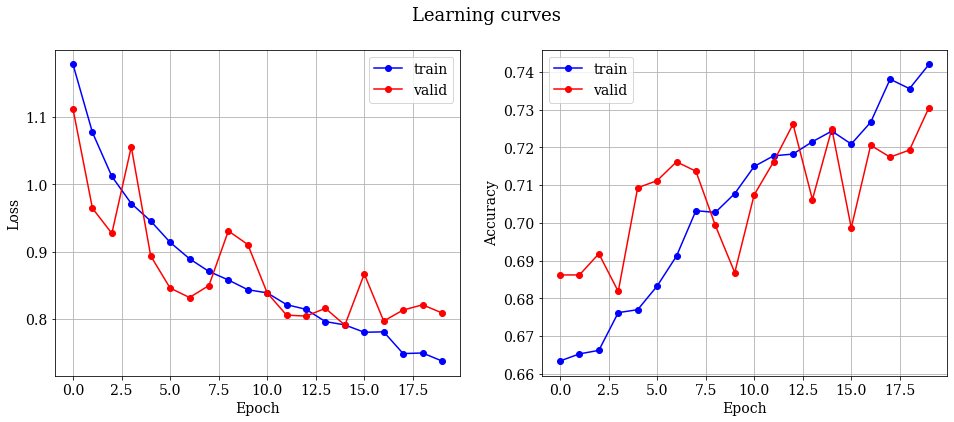

In [8]:
plot_learning_curve(history.history)

In [9]:
y_true = np.argmax(y_valid, axis=1) # From one-hot encoding to label
y_pred = cnn.predict(X_img_valid)  # Make predictions
y_pred = np.argmax(y_pred, axis=1)  # Take the maximum probability for each prediction

print(f"Accuracy  : {100 * accuracy_score(y_true, y_pred):.2f}")
print(f"Recall    : {100 * recall_score(y_true, y_pred, average='macro'):.2f}")
print(f"Precision : {100 * precision_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")
print(f"F1        : {100 * f1_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")

Accuracy  : 72.69
Recall    : 28.43
Precision : 67.33
F1        : 68.60


In [10]:
# Build a single 2D-CNN network
cnn_tda = get_cnn_tda_net(method=method, input_shape=input_shape, n_classes=n_classes)
# Define a loss function, an optimization method, and evaluate metrics
cnn_tda.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# Train the model
history = cnn_tda.fit(
    [X_img_train, X_tda_train], y_train,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    epochs=20
)

Epoch 1/20
201/201 [==============================] - 2s 7ms/step - loss: 1.1237 - acc: 0.6642 - val_loss: 0.9980 - val_acc: 0.6875
Epoch 2/20
201/201 [==============================] - 1s 6ms/step - loss: 0.9737 - acc: 0.6719 - val_loss: 0.9157 - val_acc: 0.6937
Epoch 3/20
201/201 [==============================] - 1s 7ms/step - loss: 0.9239 - acc: 0.6789 - val_loss: 0.8587 - val_acc: 0.7062
Epoch 4/20
201/201 [==============================] - 1s 6ms/step - loss: 0.9088 - acc: 0.6892 - val_loss: 0.9825 - val_acc: 0.7093
Epoch 5/20
201/201 [==============================] - 1s 6ms/step - loss: 0.8996 - acc: 0.6890 - val_loss: 0.8454 - val_acc: 0.7155
Epoch 6/20
201/201 [==============================] - 1s 6ms/step - loss: 0.8816 - acc: 0.6917 - val_loss: 0.8472 - val_acc: 0.7143
Epoch 7/20
201/201 [==============================] - 1s 6ms/step - loss: 0.8750 - acc: 0.6981 - val_loss: 0.8345 - val_acc: 0.7180
Epoch 8/20
201/201 [==============================] - 1s 6ms/step - loss: 0.

In [11]:
history_cnn_tda = history.history

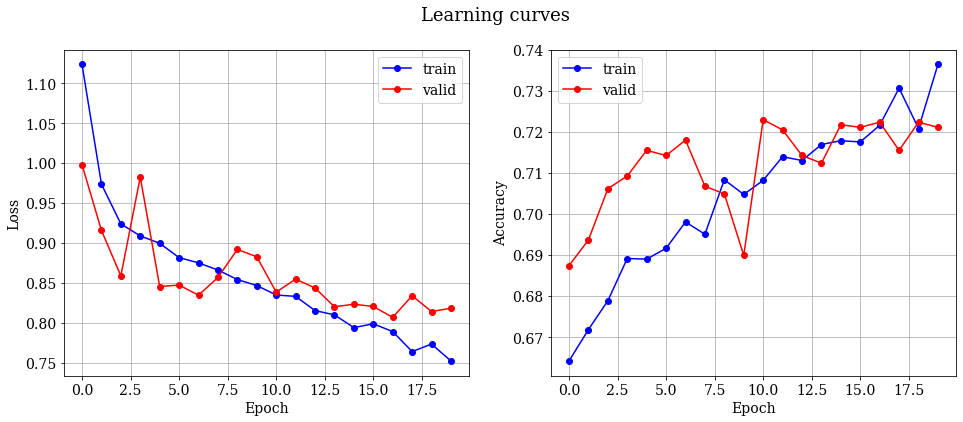

In [12]:
plot_learning_curve(history.history)

In [13]:
y_true = np.argmax(y_valid, axis=1) # From one-hot encoding to label
y_pred = cnn_tda.predict([X_img_valid, X_tda_valid])  # Make predictions
y_pred = np.argmax(y_pred, axis=1)  # Take the maximum probability for each prediction

print(f"Accuracy  : {100 * accuracy_score(y_true, y_pred):.2f}")
print(f"Recall    : {100 * recall_score(y_true, y_pred, average='macro'):.2f}")
print(f"Precision : {100 * precision_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")
print(f"F1        : {100 * f1_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")

Accuracy  : 71.84
Recall    : 31.06
Precision : 66.90
F1        : 67.72


In [14]:
from tensorflow import keras
class GradCAMOnCNNTDANet:
    def __init__(self, model, local_layer_name, global_layer_name):
        self.model = model
        self._grad_model = self._get_grad_model(self.model, local_layer_name, global_layer_name)
        self.__dict__['_cache'] = {}
        
    def to_heatmap(self, inputs, true_label=None):
        # Grab the inputs
        self._cache['img'] = np.uint8(255 * inputs[0]).squeeze(0)
        self._cache['tda'] = inputs[1].squeeze(0)
        
        local_heatmap = self._compute_local_heatmap(inputs, true_label)
        global_heatmap = self._compute_global_heatmap(inputs,true_label)
        self._cache['heatmap'] = [local_heatmap, global_heatmap]
        
    def _compute_local_heatmap(self, inputs, pred_index=None):
        with tf.GradientTape() as tape:
            local_layer_output, global_layer_output, preds = self._grad_model(inputs)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
                self._cache['pred'] = pred_index.numpy()
            class_channel = preds[:, pred_index]
            
        grads = tape.gradient(class_channel, local_layer_output)
        pooled_grads = tf.reduce_mean(grads, (0, 1, 2))
        local_layer_output = tf.squeeze(local_layer_output)
        
        heatmap = local_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

        heatmap = np.uint8(255 * heatmap)[..., np.newaxis]
        heatmap = keras.preprocessing.image.array_to_img(heatmap) # np.ndarray -> PIL.Image
        heatmap = heatmap.resize((self._cache['img'].shape[1], self._cache['img'].shape[0]))  # Resizing
        heatmap = keras.preprocessing.image.img_to_array(heatmap)  # PIL.Image -> np.ndarray

        return heatmap
    
    def _compute_global_heatmap(self, inputs, pred_index=None):
        with tf.GradientTape() as tape:
            local_layer_output, global_layer_output, preds = self._grad_model(inputs)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
                self._cache['pred'] = pred_index.numpy()
            class_channel = preds[:, pred_index]
            
        grads = tape.gradient(class_channel, global_layer_output)
        pooled_grads = tf.reduce_mean(grads, (0, 1, 2))
        global_layer_output = tf.squeeze(global_layer_output)
        
        heatmap = global_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

        heatmap = np.uint8(255 * heatmap)[..., np.newaxis]
        heatmap = keras.preprocessing.image.array_to_img(heatmap) # np.ndarray -> PIL.Image
        heatmap = heatmap.resize((self._cache['img'].shape[1], self._cache['img'].shape[0]))  # Resizing
        heatmap = keras.preprocessing.image.img_to_array(heatmap)  # PIL.Image -> np.ndarray

        return heatmap
    
    def _get_grad_model(self, model, local_layer_name, global_layer_name):
        # Get models
        local_pipeline = model.get_layer('img_network')
        global_pipeline = model.get_layer('tda_network')
        tail = model.get_layer('head')

        # Define forward pass
        local_input = local_pipeline.inputs
        local_flatten = local_pipeline.output

        global_input = global_pipeline.inputs
        global_flatten = global_pipeline.output

        concat = model.get_layer('concatenate')([local_flatten, global_flatten])
        output = tail(concat)

        local_layer_output = local_pipeline.get_layer(local_layer_name).output
        global_layer_output = global_pipeline.get_layer(global_layer_name).output

        return keras.models.Model([local_input, global_input], [local_layer_output, global_layer_output, output])


In [27]:
alpha = 0.7
dir_figure = './outputs/figures'
gradcam_cnn = GradCAMOnCNN(cnn, layer_name='conv2d_3')
gradcam_cnn_tda = GradCAMOnCNNTDANet(cnn_tda, local_layer_name='conv2d_8', global_layer_name='conv2d_13')
indices = [25, 169, 0, 103]
for i, idx in enumerate(indices):
    # Sample
    img = X_img_valid[idx:idx+1]
    tda = X_tda_valid[idx:idx+1]
    label = np.argmax(y_valid, axis=1)[idx]

    # Original image
    fig = plt.figure(figsize=(4, 4), frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.set_size_inches(4, 4)
    ax.imshow(img[0, :, :, 0], cmap='gray')
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.savefig(os.path.join(dir_figure, f'figureB2a_{i+1}r.pdf'), dpi=100)
    plt.cla()
    plt.clf()
    plt.close()

    # Grad-CAM of the single CNN
    gradcam_cnn.to_heatmap(img)
    fig = plt.figure(figsize=(4, 4), frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.set_size_inches(4, 4)
    ax.imshow(img[0, :, :, 0], cmap='gray')
    ax.imshow(gradcam_cnn._cache['heatmap'][0], cmap='jet', alpha=alpha)
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.savefig(os.path.join(dir_figure, f'figureB2b_{i+1}r.pdf'), dpi=100)
    plt.cla()
    plt.clf()
    plt.close()

    # Grad-CAM of the CNN-PL Net's image network
    gradcam_cnn_tda.to_heatmap([img, tda])
    fig = plt.figure(figsize=(4, 4), frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.set_size_inches(4, 4)
    ax.imshow(img[0, :, :, 0], cmap='gray')
    ax.imshow(gradcam_cnn_tda._cache['heatmap'][0], cmap='jet', alpha=alpha)
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.savefig(os.path.join(dir_figure, f'figureB2c_{i+1}r.pdf'), dpi=100)
    plt.cla()
    plt.clf()
    plt.close()

    # 0D-Persistence image Grad-CAM of the CNN-PL Net's topology network
    fig = plt.figure(figsize=(4, 4), frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.set_size_inches(4, 4)
    ax.imshow(gradcam_cnn_tda._cache['tda'][:, :, 0], cmap='gray')
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.savefig(os.path.join(dir_figure, f'figureB2d_{i+1}r.pdf'), dpi=100)
    plt.cla()
    plt.clf()
    plt.close()

    # 0D-Persistence image Grad-CAM of the CNN-PL Net's topology network
    fig = plt.figure(figsize=(4, 4), frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.set_size_inches(4, 4)
    ax.imshow(gradcam_cnn_tda._cache['tda'][:, :, 1], cmap='gray')
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.savefig(os.path.join(dir_figure, f'figureB2e_{i+1}r.pdf'), dpi=100)
    plt.cla()
    plt.clf()
    plt.close()

    # 0D-Persistence image Grad-CAM of the CNN-PL Net's topology network
    fig = plt.figure(figsize=(4, 4), frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.set_size_inches(4, 4)
    ax.imshow(gradcam_cnn_tda._cache['tda'][:, :, 0], cmap='gray', alpha=0.9)
    ax.imshow(gradcam_cnn_tda._cache['tda'][:, :, 1], cmap='gray', alpha=0.9)
    ax.imshow(gradcam_cnn_tda._cache['heatmap'][1], cmap='jet', alpha=0.7)
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.savefig(os.path.join(dir_figure, f'figureB2f_{i+1}r.pdf'), dpi=100)
    plt.cla()
    plt.clf()
    plt.close()
